In [1]:
!pip install glum
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.4 MB/s eta 0:00:00


In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_poisson_deviance
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

if not "glum" in sys.modules:
    !pip install glum==3.0

from glum import GeneralizedLinearRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: glum
    Found existing installation: glum 3.0.1
    Uninstalling glum-3.0.1:
      Successfully uninstalled glum-3.0.1


Top rows of the data
     year  town  driver_age  car_weight  car_power  car_age  claim_nb
0  2018.0   1.0        51.0      1760.0      173.0      3.0       0.0
1  2019.0   1.0        41.0      1760.0      248.0      2.0       0.0
2  2018.0   1.0        25.0      1240.0      111.0      2.0       0.0
3  2019.0   0.0        40.0      1010.0       83.0      9.0       0.0
4  2018.0   0.0        43.0      2180.0      169.0      5.0       0.0



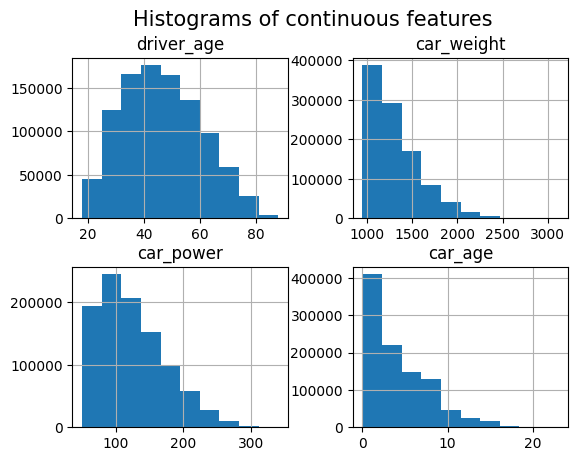

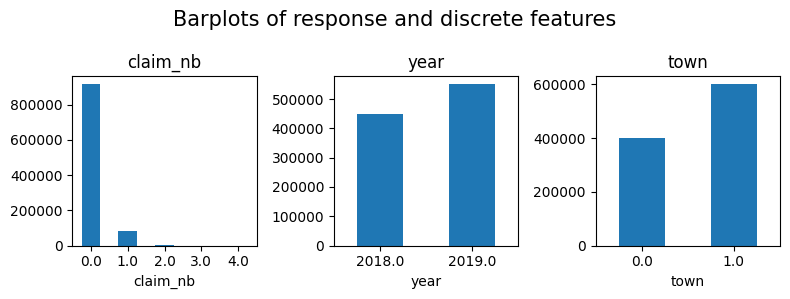

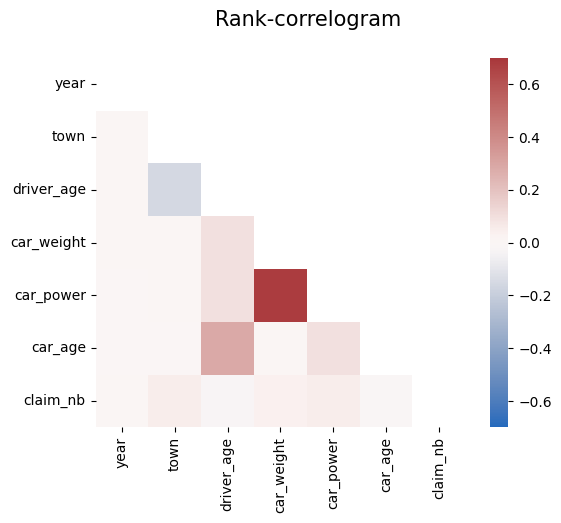

In [3]:
df = fetch_openml(data_id=45106, parser="pandas").frame
print("Top rows of the data")
print(df.head().to_string(), end="\n\n")

# Continuous features
df.hist(["driver_age", "car_weight", "car_power", "car_age"])
_ = plt.suptitle("Histograms of continuous features", fontsize=15)

# Response and discrete features
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["claim_nb", "year", "town"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)
plt.suptitle("Barplots of response and discrete features", fontsize=15)
plt.tight_layout()
plt.show()

# Rank correlations
corr = df.corr("spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.suptitle("Rank-correlogram", fontsize=15)
_ = sns.heatmap(
    corr, mask=mask, vmin=-0.7, vmax=0.7, center=0, cmap="vlag", square=True
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("claim_nb", axis=1), df["claim_nb"], test_size=0.1, random_state=30
)

params = dict(
    learning_rate=0.05,
    objective="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

model_lgb = LGBMRegressor(n_estimators=360, **params)
model_lgb.fit(X_train, y_train)

LGBMRegressor(colsample_bynode=0.8, learning_rate=0.05, min_child_samples=50,
              n_estimators=360, num_leaves=7, objective='poisson', reg_alpha=3,
              reg_lambda=5, subsample=0.8, verbose=-1)

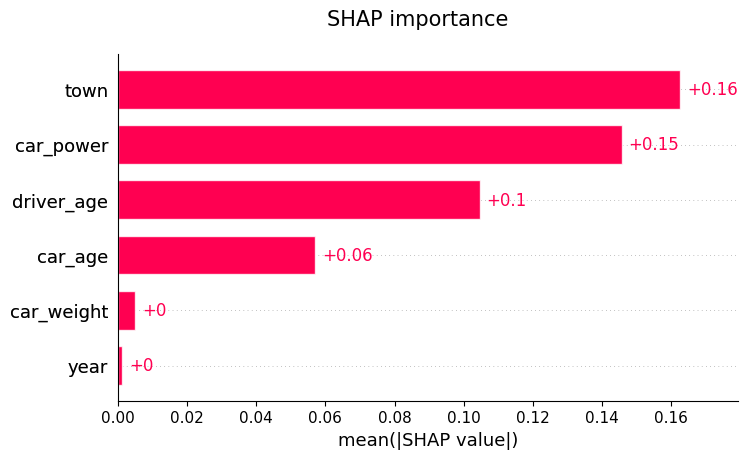

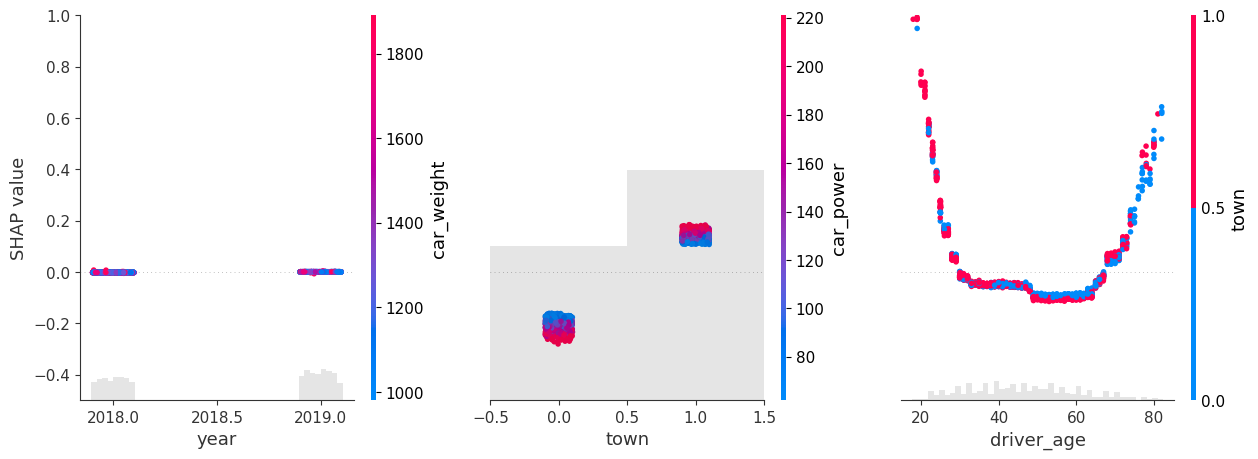

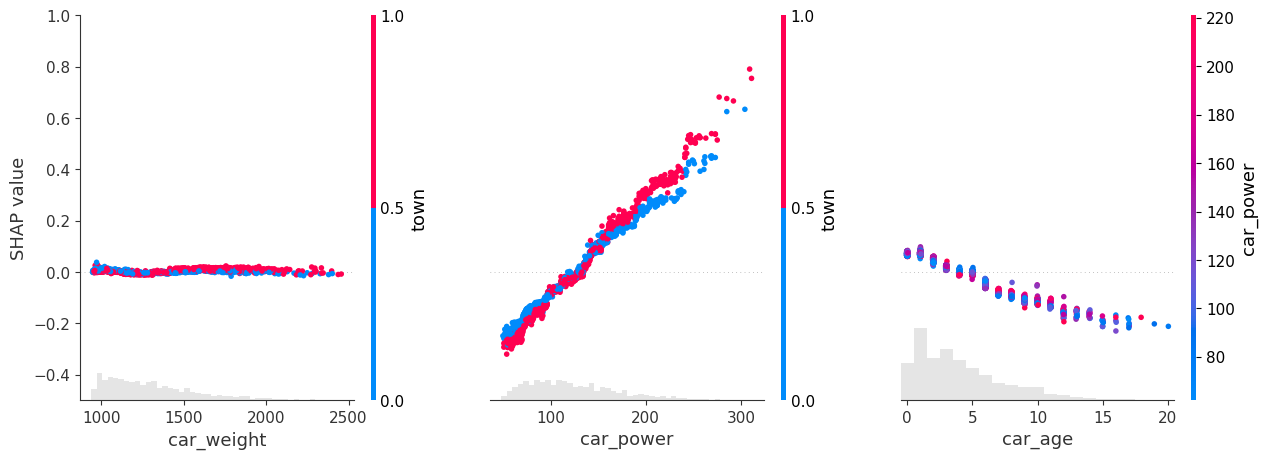

In [5]:
X_explain = X_train.sample(n=2000, random_state=937)
explainer = shap.Explainer(model_lgb)
shap_val = explainer(X_explain)

plt.suptitle("SHAP importance", fontsize=15)
shap.plots.bar(shap_val)

for s in [shap_val[:, 0:3], shap_val[:, 3:]]:
    shap.plots.scatter(s, color=shap_val, ymin=-0.5, ymax=1)

In [6]:
model_glm = GeneralizedLinearRegressor(
    family="poisson",
    formula="car_power * town + bs(driver_age, 7) + car_age"
)
model_glm.fit(X_train, y=y_train, store_covariance_matrix=True)
model_glm.coef_table()

,coef,se,t_value,p_value,ci_lower,ci_upper
intercept,-1.788171,0.039748,-44.988146,0.000000,-1.866075,-1.710267
car_power,0.003030,0.000122,24.869398,0.000000,0.002791,0.003269
town,0.178508,0.020893,8.543944,0.000000,0.137559,0.219458
"bs(driver_age, 7)[1]",-0.919252,0.064083,-14.344799,0.000000,-1.044851,-0.793652
"bs(driver_age, 7)[2]",-1.319980,0.034303,-38.480503,0.000000,-1.387212,-1.252749
"bs(driver_age, 7)[3]",-1.182443,0.043335,-27.286028,0.000000,-1.267378,-1.097507
"bs(driver_age, 7)[4]",-1.280497,0.037852,-33.828892,0.000000,-1.354686,-1.206308
"bs(driver_age, 7)[5]",-1.345355,0.052420,-25.664948,0.000000,-1.448096,-1.242614
"bs(driver_age, 7)[6]",-0.913210,0.066033,-13.829595,0.000000,-1.042632,-0.783787
"bs(driver_age, 7)[7]",-0.093738,0.092183,-1.016876,0.309212,-0.274413,0.086936


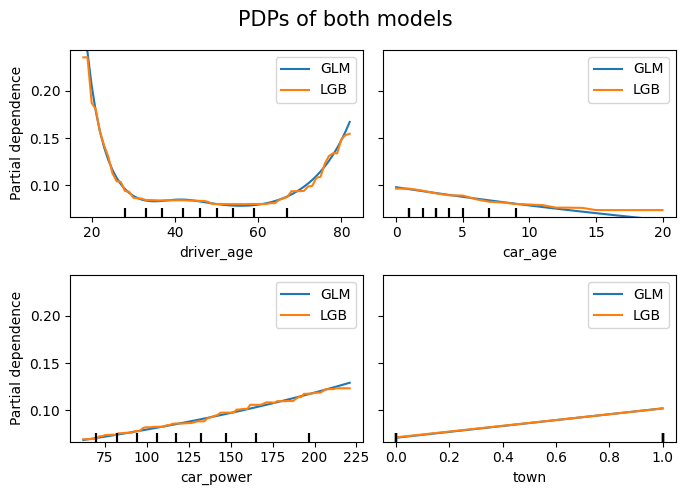

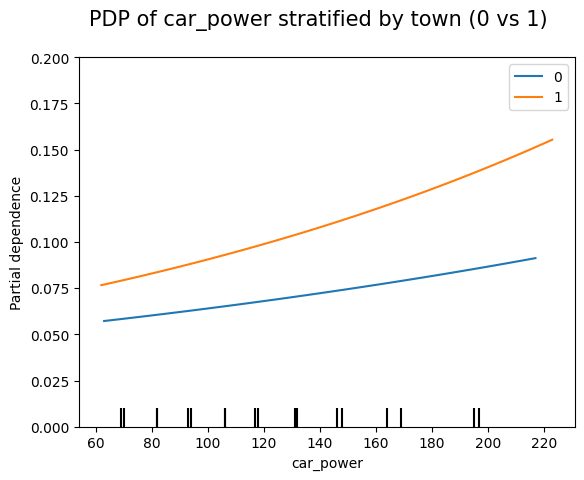

In [7]:
# PDPs of both models
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
cols = ("tab:blue", "tab:orange")
for color, name, model in zip(cols, ("GLM", "LGB"), (model_glm, model_lgb)):
    disp = PartialDependenceDisplay.from_estimator(
        model,
        features=["driver_age", "car_age", "car_power", "town"],
        X=X_explain,
        ax=ax if name == "GLM" else disp.axes_,
        line_kw={"label": name, "color": color},
    )
fig.suptitle("PDPs of both models", fontsize=15)
fig.tight_layout()

# Stratified PDP of car_power
for color, town in zip(("tab:blue", "tab:orange"), (0, 1)):
    mask = X_explain.town == town
    disp = PartialDependenceDisplay.from_estimator(
        model_glm,
        features=["car_power"],
        X=X_explain[mask],
        ax=None if town == 0 else disp.axes_,
        line_kw={"label": town, "color": color},
    )


plt.suptitle("PDP of car_power stratified by town (0 vs 1)", fontsize=15)
_ = plt.ylim(0, 0.2)

In [8]:
model_dummy = DummyRegressor().fit(X_train, y=y_train)
deviance_null = mean_poisson_deviance(y_test, model_dummy.predict(X_test))

dev_imp = []
for name, model in zip(("GLM", "LGB", "Null"), (model_glm, model_lgb, model_dummy)):
    dev_imp.append((name, mean_poisson_deviance(y_test, model.predict(X_test))))
pd.DataFrame(dev_imp, columns=["Model", "Mean_Poisson_Deviance"])

,Model,Mean_Poisson_Deviance
0,GLM,0.432187
1,LGB,0.432283
2,Null,0.442581
